In [1]:
from bioMass.backbones import utae, unet3d, convlstm, convgru, fpn, ltae
import torch
from bioMass.dataloader2 import SentinelYearlyDataset, SentinelDataModule
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

%config Completer.use_jedi = False
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Simple model run

In [2]:
model = utae.UTAE(
    input_dim=4,
    out_conv=[32, 1]
)

In [3]:
batch_size = 2

x = torch.rand((batch_size, 12, 4, 256, 256))
bp = torch.Tensor(range(12)).repeat(batch_size).reshape(batch_size, 12)

model(x, batch_positions=bp).shape

torch.Size([2, 1, 256, 256])

# Run with the Sentinel dataModule

In [3]:
dm = SentinelDataModule(is_train=True, max_chips=None, loader_device='cpu', num_workers=12, split_proportions=[0.8, 0.2, 0],
                        batch_size=12)
dm.setup('fit')

bp = torch.Tensor(range(12)).repeat(dm.batch_size).reshape(dm.batch_size, 12)

train_dataloader = dm.train_dataloader()
len(train_dataloader)

In [4]:
model = utae.UTAE(
    input_dim=4, # Sentinel 1 has 4 channels, Sentinel 2 has 11
    out_conv=[32, 1]
)

model = model.to('cuda')

for batch in train_dataloader:
    batch
    break

/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backe

In [6]:
# 31.3 GB of VRAM at batch size of 12
image_s1, image_s2, target = batch['image_s1'], batch['image_s2'], batch['target']
image_s1, image_s2, target = image_s1.to('cuda'), image_s2.to('cuda'), target.to('cuda')
print(image_s1.shape)
print(model(image_s1, batch_positions=bp.to('cuda')).shape)

torch.Size([12, 12, 4, 256, 256])
torch.Size([12, 1, 256, 256])


In [5]:
image_s1, image_s2, target = batch['image_s1'], batch['image_s2'], batch['target']

In [12]:
torch.concat([image_s1, image_s2], axis=2).shape

torch.Size([12, 12, 15, 256, 256])

In [8]:
image_s1.shape, image_s2.shape

(torch.Size([12, 12, 4, 256, 256]), torch.Size([12, 12, 11, 256, 256]))

# Sanity Checks

## Input and target have same distribution

In [2]:
dm = SentinelDataModule(is_train=True, max_chips=None, loader_device='cpu', num_workers=24, split_proportions=[0.8, 0.2, 0],
                        batch_size=2)
dm.setup('fit')

bp = torch.Tensor(range(12)).repeat(dm.batch_size).reshape(dm.batch_size, 12)

train_dataloader = dm.train_dataloader()
len(train_dataloader)

3476

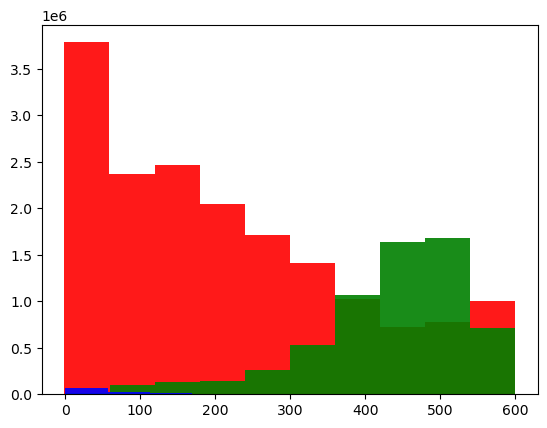

In [3]:
for sample in train_dataloader:
    image_s2, image_s1, target = sample['image_s2'].numpy(), sample['image_s1'].numpy(), sample['target'].numpy()
    plt.hist(image_s2.flatten(), color='r', alpha=0.9)
    plt.hist(image_s1.flatten(), color='g', alpha=0.9)
    plt.hist(target.flatten(), color='b', alpha=0.9)
    plt.show()
    break

In [4]:
model = utae.UTAE(
    input_dim=11, # Sentinel 1 has 4 channels, Sentinel 2 has 11
    out_conv=[32, 1]
)

model = model.to('cuda')

(array([7.5136e+05, 2.3965e+04, 7.2500e+03, 2.5800e+03, 8.4600e+02,
        2.8400e+02, 9.6000e+01, 3.8000e+01, 9.0000e+00, 4.0000e+00]),
 array([ 0.        ,  1.6758343 ,  3.3516686 ,  5.02750301,  6.70333719,
         8.37917137, 10.05500603, 11.73083973, 13.40667439, 15.08250809,
        16.75834274]),
 <BarContainer object of 10 artists>)

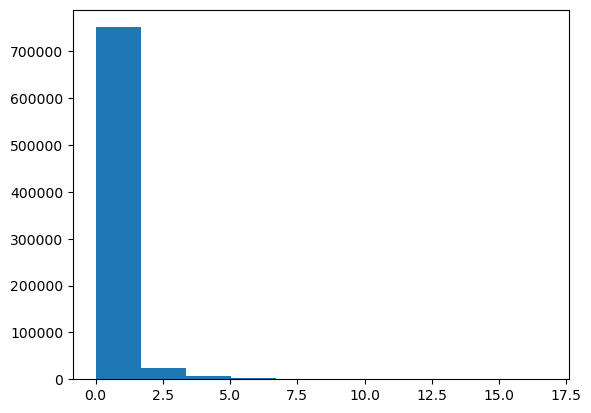

In [6]:
x = torch.Tensor(image_s2).to('cuda')
with torch.no_grad():
    x = model(x, batch_positions=bp.to('cuda')).cpu().detach().numpy().flatten()
plt.hist(x)

## Trick 3: Detecting Anomalies in the Forward Pass

https://www.pytorchlightning.ai/blog/3-simple-tricks-that-will-change-the-way-you-debug-pytorch

The idea is simple: If we change the n-th input sample, it should only have an effect on the n-th output. If other outputs i ≠ n also change, the model mixes data and that’s not good! A reliable way to implement this test is to compute the gradient on the n-th output with respect to all inputs. The gradient must be zero for all i ≠ n (red in the animation above) and nonzero for i = n (green in the animation above). If these conditions are met, the model passes the test. Below is the implementation for n = 3:

In [16]:
model = model.to('cuda')

In [17]:
# examine the gradient of the n-th minibatch sample w.r.t. all inputs
n = 0  

# 1. require gradient on input batch
example_input = torch.rand_like(torch.Tensor(image_s2), requires_grad=True).to('cuda')

# 2. run batch through model
output = model(example_input, batch_positions=bp.to('cuda'))

# 3. compute a dummy loss on n-th output sample and back-propagate
output[n].abs().sum().backward()

# 4. check that gradient on samples i != n are zero!
# sanity check: if this does not return 0, you have a bug!
i = 0
example_input.grad[i].abs().sum().item()

TypeError: 'NoneType' object is not subscriptable

In [21]:
example_input.grad

In [38]:
# examine the gradient of the n-th minibatch sample w.r.t. all inputs
n = 0

# 1. require gradient on input batch
example_input = torch.rand_like(torch.Tensor(image_s2), requires_grad=True)

# 2. run batch through model
output = model(example_input)

# 3. compute a dummy loss on n-th output sample and back-propagate
output[n].abs().sum().backward()

# 4. check that gradient on samples i != n are zero!
# sanity check: if this does not return 0, you have a bug!
zero_grad_inds = list(range(example_input.size(0)))     
zero_grad_inds.pop(n)


if example_input.grad[zero_grad_inds].abs().sum().item() > 0:
    raise RuntimeError("Your model mixes data across the batch dimension!")